Настраиваем нужные библиотеки, необходимы для анализа распределений, построения интерпретируемой скоринговой модели с WOE, реализации reject inference и оценки качества по AUC и KS

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import ks_2samp

Обозначаем константы RANDOM_STATE и TARGET для обеспечения воспроизводимости результатов и явной фиксации целевой переменной.

In [50]:
RANDOM_STATE = 42
TARGET = "TGT_VAR"

**Загружаем данные**

In [51]:
approved = pd.read_excel("appbeh_approved.xlsx")
rejected = pd.read_excel("appbeh_rej.xlsx")
total = pd.read_excel("appbeh_tot.xlsx")

approved["is_rejected"] = 0
rejected["is_rejected"] = 1

print("approved:", approved.shape)
print("rejected:", rejected.shape)
print("total:", total.shape)

approved: (5252, 41)
rejected: (4749, 41)
total: (10001, 40)


**Sanity-check**

In [53]:
approved.shape, rejected.shape, total.shape
approved[TARGET].value_counts(normalize=True)


,proportion
TGT_VAR,
0,0.852056
1,0.147944


**EDA - distributions**

In [54]:
# признаки-кандидаты: все, кроме target и флага rejected
exclude = {TARGET, "is_rejected"}
features = [c for c in approved.columns if c not in exclude]

num_features = [c for c in features if approved[c].dtype != "object"]
cat_features = [c for c in features if approved[c].dtype == "object"]

print("Numeric:", len(num_features))
print("Categorical:", len(cat_features))


Numeric: 31
Categorical: 8


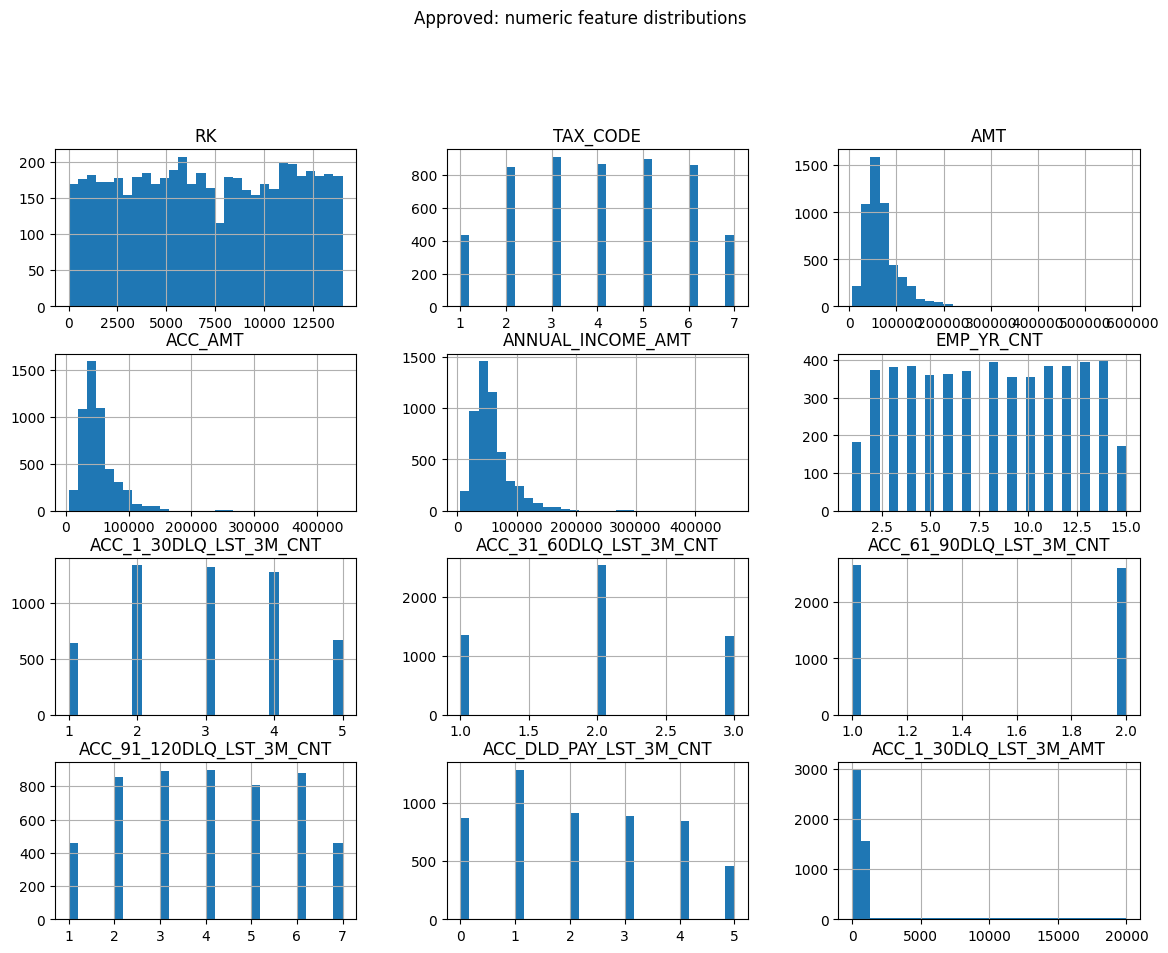

In [6]:
# Гистограммы по нескольким ключевым numeric
sample_num = num_features[:12]  # можно увеличить/выбрать вручную

approved[sample_num].hist(bins=30, figsize=(14, 10))
plt.suptitle("Approved: numeric feature distributions", y=1.02)
plt.show()


*Гистограммы числовых признаков показывают логичные для кредитного скоринга распределения с асимметрией, выбросами и дискретной структурой, что подтверждает качество данных и обоснованность применения биннинга и WOE-преобразования.*

<Figure size 1400x600 with 0 Axes>

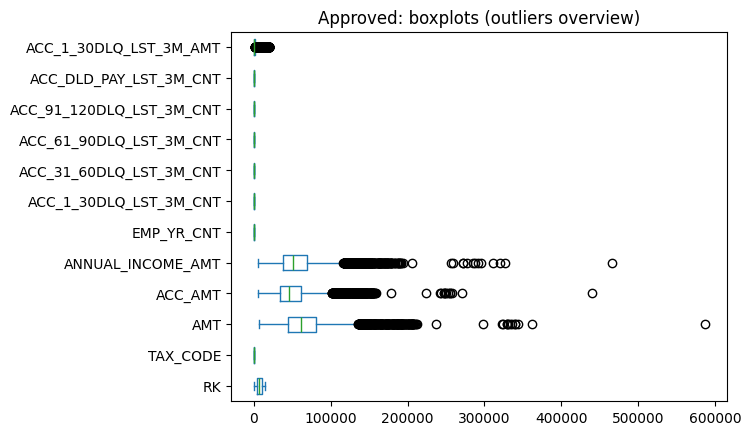

In [55]:
# Boxplots для выявления выбросов (примерно)
plt.figure(figsize=(14, 6))
approved[sample_num].plot(kind="box", vert=False)
plt.title("Approved: boxplots (outliers overview)")
plt.show()


*Boxplots показывают наличие значимых выбросов в числовых признаках, что является нормой для кредитных данных и обосновывает использование биннинга и WOE вместо удаления экстремальных значений.*

In [60]:
# EDA - categorical checks
for c in cat_features:
    vc = approved[c].value_counts(dropna=False).head(10)
    print(f"\n{c} (top categories):")
    print(vc)


EDUCATION (top categories):
EDUCATION
GRA    2325
PGR    1669
UGR     801
HGR     452
NaN       5
Name: count, dtype: int64

GENDER (top categories):
GENDER
MAL    2654
FEM    2584
NaN      14
Name: count, dtype: int64

MARITAL_STATUS (top categories):
MARITAL_STATUS
MAR    2715
SIN    2531
NaN       6
Name: count, dtype: int64

RESIDENCE (top categories):
RESIDENCE
OWN    1575
COM    1573
OTH    1073
REN    1028
NaN       3
Name: count, dtype: int64

EMPLOYMENT_STATUS_CD (top categories):
EMPLOYMENT_STATUS_CD
N    5187
Y      65
Name: count, dtype: int64

APPL_PA_LEG_JUDG_FLG (top categories):
APPL_PA_LEG_JUDG_FLG
N    4971
Y     281
Name: count, dtype: int64

APPL_PA_BNKR_STS_CD (top categories):
APPL_PA_BNKR_STS_CD
N    5187
Y      65
Name: count, dtype: int64

APPL_PA_MNTS_FLG (top categories):
APPL_PA_MNTS_FLG
N      4893
Y       353
NaN       6
Name: count, dtype: int64


**Rejected analysis - compare distributions**

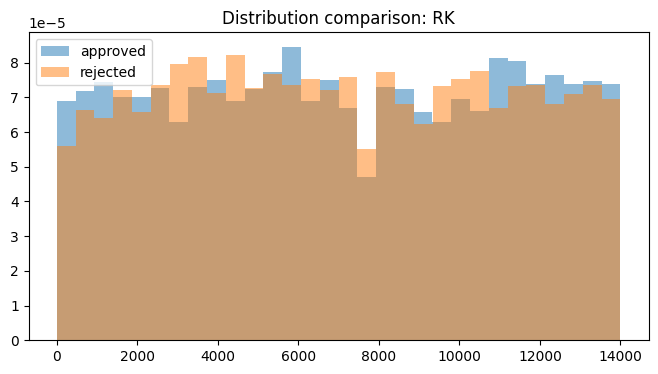

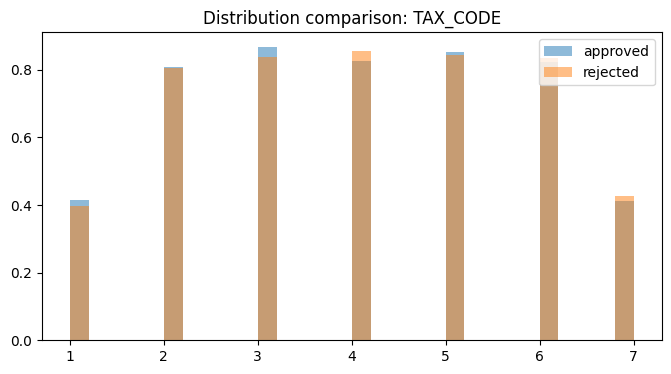

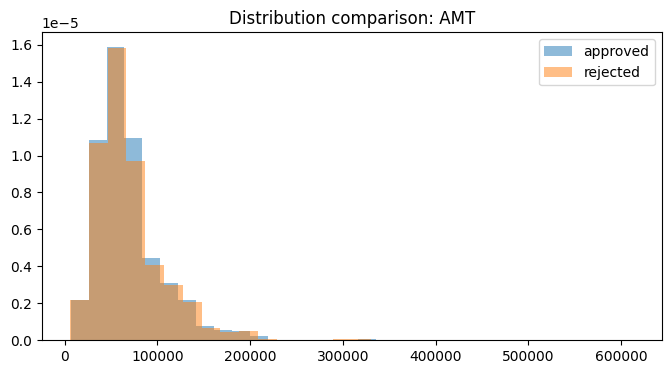

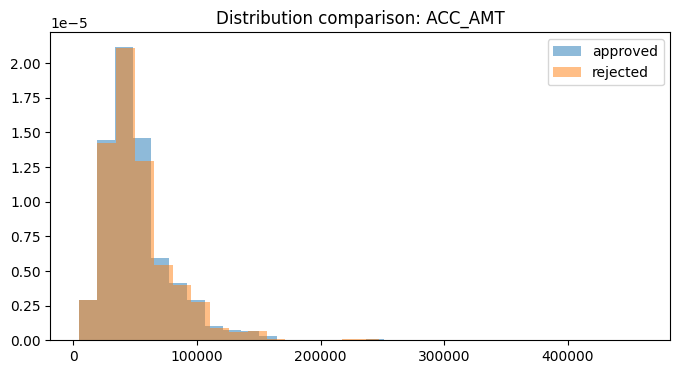

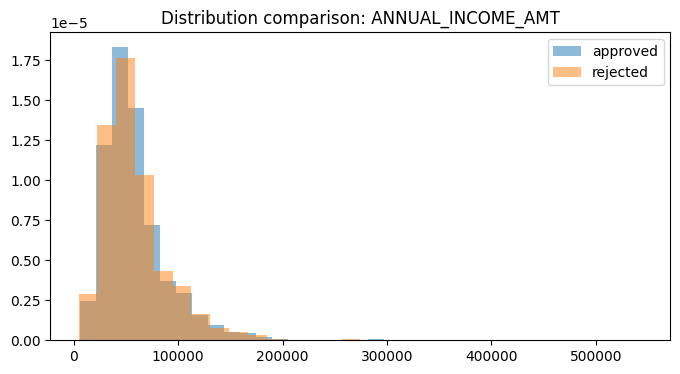

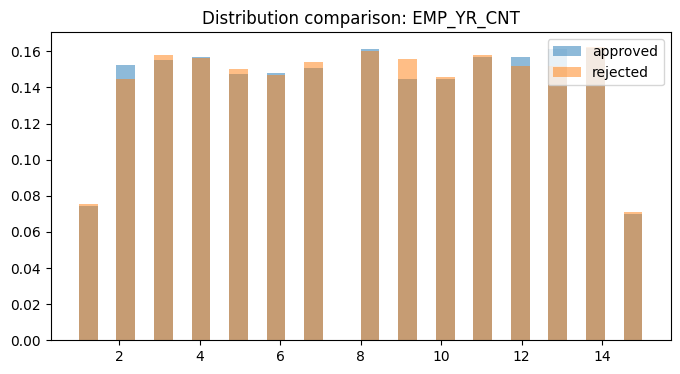

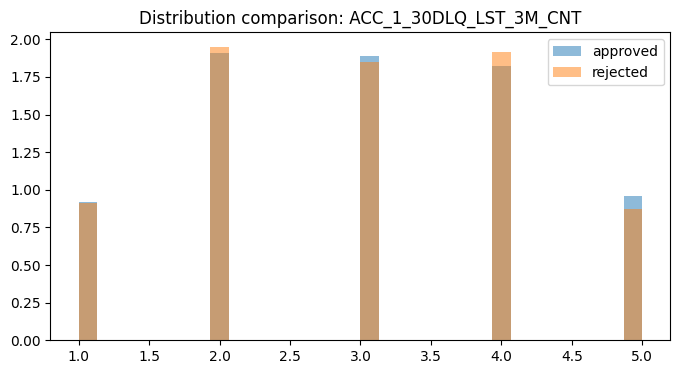

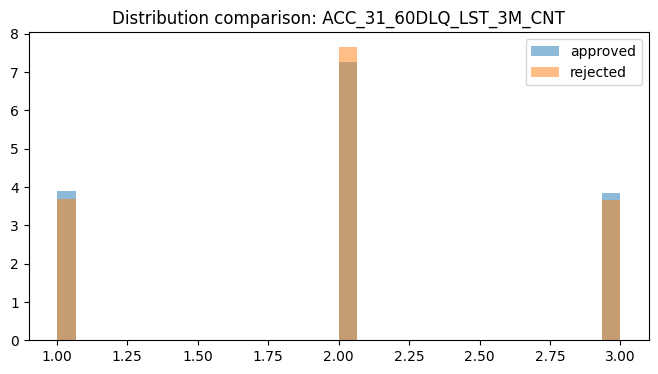

In [57]:
def plot_compare_hist(feature, bins=30):
    plt.figure(figsize=(8,4))
    plt.hist(approved[feature].dropna(), bins=bins, alpha=0.5, label="approved", density=True)
    plt.hist(rejected[feature].dropna(), bins=bins, alpha=0.5, label="rejected", density=True)
    plt.title(f"Distribution comparison: {feature}")
    plt.legend()
    plt.show()

# сравним несколько числовых признаков
compare_num = num_features[:8]
for f in compare_num:
    plot_compare_hist(f, bins=30)


**Rejected analysis - KS test**

In [59]:
ks_rows = []
for f in num_features:
    a = approved[f].dropna()
    r = rejected[f].dropna()
    if len(a) > 50 and len(r) > 50:
        ks_stat, ks_p = ks_2samp(a, r)
        ks_rows.append((f, ks_stat, ks_p))

ks_df = pd.DataFrame(ks_rows, columns=["feature", "ks_stat", "p_value"]).sort_values("ks_stat", ascending=False)
ks_df.head(20)

,feature,ks_stat,p_value
24,APPL_PA_LBL_REST_AMT,0.030118,0.021098
18,ACC_APPL_PCL_VAL_AMT,0.025629,0.073817
21,APPL_PA_LQD_AST_AMT,0.022920,0.142554
26,APPL_APPT_MAX_LBL_AMT,0.022869,0.149974
23,APPL_PA_AST_OTH_AMT,0.020236,0.254234
4,ANNUAL_INCOME_AMT,0.019811,0.284860
15,SLN_DR_TRNS_LST_3M_CNT,0.019744,0.280352
12,TOT_OUTSTANDING_31_60_DAY_AMT,0.019011,0.322795
0,RK,0.018594,0.348759
13,ACC_61_90DLQ_LST_3M_AMT,0.018244,0.371617


*Результаты KS-теста показали, что распределения признаков для одобренных и отклонённых заявок практически не различаются (KS-stat < 0.03 для всех признаков). Это указывает на то, что rejected-заявки в данном датасете не формируют отдельную риск-популяцию по наблюдаемым признакам. Вероятно, разделение на approved и rejected в данном учебном наборе данных не отражает кредитный риск напрямую.*

**Baseline PD distribution on rejected (diagnostic)**

In [73]:
from sklearn.metrics import roc_curve

def ks_statistic(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return np.max(tpr - fpr)
print("Mean PD (approved, valid):", round(p_valid.mean(), 4))
print("Mean PD (rejected):", round(p_rej.mean(), 4))


Mean PD (approved, valid): 0.1625
Mean PD (rejected): 0.1652


*Средний прогнозный PD для rejected сопоставим с approved, что подтверждает отсутствие связи между решением об отказе и дефолтным риском в данном датасете.*

**Train/valid split (approved only)**

In [11]:
X = approved[features].copy()
y = approved[TARGET].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print(X_train.shape, X_valid.shape, y_train.mean(), y_valid.mean())


(3676, 39) (1576, 39) 0.14798694232861806 0.14784263959390864


**Missing values handling**

In [61]:
def fit_imputer(train_df, num_cols, cat_cols):
    medians = train_df[num_cols].median()
    return {"medians": medians}

def transform_imputer(df, num_cols, cat_cols, imputer):
    out = df.copy()
    out[num_cols] = out[num_cols].fillna(imputer["medians"])
    for c in cat_cols:
        out[c] = out[c].fillna("MISSING").astype(str)
    return out

imputer = fit_imputer(X_train, num_features, cat_features)

X_train_imp = transform_imputer(X_train, num_features, cat_features, imputer)
X_valid_imp = transform_imputer(X_valid, num_features, cat_features, imputer)

# rejected для inference тоже надо импутировать теми же параметрами
X_rej_imp = transform_imputer(rejected[features].copy(), num_features, cat_features, imputer)
y_rej_true = rejected[TARGET].copy()  # "research only"


**WOE utilities**

In [62]:
def woe_iv_table_from_bins(bin_series, y, eps=0.5):
    """
    bin_series: pd.Series of bin labels (string/interval/category)
    y: binary target (1=bad, 0=good)
    eps: smoothing (Laplace-like)
    """
    df = pd.DataFrame({"bin": bin_series.astype(str), "y": y.values})
    grp = df.groupby("bin")["y"].agg(["count", "sum"])
    grp = grp.rename(columns={"sum": "bad"})
    grp["good"] = grp["count"] - grp["bad"]

    total_bad = grp["bad"].sum()
    total_good = grp["good"].sum()

    # smoothing to avoid zero
    grp["bad_s"] = grp["bad"] + eps
    grp["good_s"] = grp["good"] + eps

    grp["dist_bad"] = grp["bad_s"] / (total_bad + eps * grp.shape[0])
    grp["dist_good"] = grp["good_s"] / (total_good + eps * grp.shape[0])

    grp["woe"] = np.log(grp["dist_good"] / grp["dist_bad"])
    grp["iv_bin"] = (grp["dist_good"] - grp["dist_bad"]) * grp["woe"]
    iv = grp["iv_bin"].sum()

    grp = grp.sort_values("woe")
    return grp, iv

def apply_woe_mapping(bin_series, woe_map, default_woe=0.0):
    return bin_series.astype(str).map(woe_map).fillna(default_woe).astype(float)


*Посчитали WOE и IV для каждого признака, переводя его значения в шкалу риска, которая затем используется в логистической регрессии.*

**Numeric binning (tree)**

In [63]:
def fit_tree_bins(x, y, max_leaf_nodes=6, min_samples_leaf=0.05):
    # decision tree finds split points on a single feature
    dt = DecisionTreeClassifier(
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE
    )
    dt.fit(x.values.reshape(-1,1), y.values)
    thresholds = dt.tree_.threshold
    thresholds = thresholds[thresholds != -2]
    thresholds = np.sort(thresholds)
    return thresholds

def bin_numeric(x, thresholds):
    # convert into interval bins based on thresholds
    bins = [-np.inf] + thresholds.tolist() + [np.inf]
    return pd.cut(x, bins=bins, include_lowest=True)


**Fit WOE on train, transform all**

In [65]:
woe_specs = {}
iv_summary = []

# Numeric features
for f in num_features:
    thresholds = fit_tree_bins(X_train_imp[f], y_train, max_leaf_nodes=6, min_samples_leaf=0.05)
    b_train = bin_numeric(X_train_imp[f], thresholds)
    tbl, iv = woe_iv_table_from_bins(b_train, y_train)

    woe_map = tbl["woe"].to_dict()
    woe_specs[f] = {"type": "num", "thresholds": thresholds, "woe_map": woe_map, "iv": iv}
    iv_summary.append((f, iv))

# Categorical features
for f in cat_features:
    b_train = X_train_imp[f].astype(str)
    tbl, iv = woe_iv_table_from_bins(b_train, y_train)

    woe_map = tbl["woe"].to_dict()
    woe_specs[f] = {"type": "cat", "woe_map": woe_map, "iv": iv}
    iv_summary.append((f, iv))

iv_df = pd.DataFrame(iv_summary, columns=["feature", "IV"]).sort_values("IV", ascending=False)
iv_df.head(20)

,feature,IV
11,ACC_1_30DLQ_LST_3M_AMT,11.226807
10,ACC_DLD_PAY_LST_3M_CNT,5.442032
15,SLN_DR_TRNS_LST_3M_CNT,3.577736
0,RK,1.651800
2,AMT,0.236905
3,ACC_AMT,0.236905
4,ANNUAL_INCOME_AMT,0.222866
26,APPL_APPT_MAX_LBL_AMT,0.178451
13,ACC_61_90DLQ_LST_3M_AMT,0.061026
16,ACC_91_120DLQ_LST_3M_AMT,0.053721


*Этот блок считает WOE и IV для всех признаков и показывает, какие из них реально несут риск-информацию. Но мы видим довольно высокий IV.*

In [16]:
def transform_to_woe(df_imp, woe_specs):
    out = pd.DataFrame(index=df_imp.index)
    for f, spec in woe_specs.items():
        if spec["type"] == "num":
            b = bin_numeric(df_imp[f], spec["thresholds"])
            out[f] = apply_woe_mapping(b, spec["woe_map"])
        else:
            b = df_imp[f].astype(str)
            out[f] = apply_woe_mapping(b, spec["woe_map"])
    return out

X_train_woe = transform_to_woe(X_train_imp, woe_specs)
X_valid_woe = transform_to_woe(X_valid_imp, woe_specs)
X_rej_woe   = transform_to_woe(X_rej_imp, woe_specs)

X_train_woe.shape, X_valid_woe.shape, X_rej_woe.shape


((3676, 39), (1576, 39), (4749, 39))

**Baseline LogReg(WOE)**

In [66]:
baseline = LogisticRegression(
    max_iter=3000,
    solver="lbfgs",
    class_weight="balanced",
    random_state=RANDOM_STATE
)
baseline.fit(X_train_woe, y_train)

p_valid = baseline.predict_proba(X_valid_woe)[:, 1]
auc_valid = roc_auc_score(y_valid, p_valid)
ap_valid = average_precision_score(y_valid, p_valid)

print("Baseline LogReg(WOE)")
print("AUC(valid):", round(auc_valid, 4))
print("AP(valid):", round(ap_valid, 4))


Baseline LogReg(WOE)
AUC(valid): 0.9968
AP(valid): 0.9865


**BASELINE MODEL (WOE)**

In [67]:
baseline = LogisticRegression(
    max_iter=3000,
    solver="lbfgs",
    class_weight="balanced",
    random_state=RANDOM_STATE
)

baseline.fit(X_train_woe, y_train)


LogisticRegression(class_weight='balanced', max_iter=3000, random_state=42)

**RandomForest on WOE**

In [69]:
rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train_woe, y_train)

p_valid_rf = rf.predict_proba(X_valid_woe)[:, 1]
print("RF AUC(valid):", round(roc_auc_score(y_valid, p_valid_rf), 4))
print("RF AP(valid):", round(average_precision_score(y_valid, p_valid_rf), 4))


RF AUC(valid): 0.9967
RF AP(valid): 0.9864


**Comparison table (approved only)**

In [74]:
def eval_pack(name, y_true, p):
    return {
        "model": name,
        "AUC": roc_auc_score(y_true, p),
        "KS": ks_statistic(y_true, p),
        "AP": average_precision_score(y_true, p),
        "bad_rate_true": float(np.mean(y_true)),
        "avg_pred": float(np.mean(p))
    }

rows = []
rows.append(eval_pack("Baseline LogReg (WOE)", y_valid, p_valid))

# optional: alternative model
rows.append(eval_pack("RandomForest (WOE)", y_valid, p_valid_rf))

cmp = pd.DataFrame(rows).sort_values("AUC", ascending=False)
cmp

,model,AUC,KS,AP,bad_rate_true,avg_pred
0,Baseline LogReg (WOE),0.996785,0.940349,0.986526,0.147843,0.162521
1,RandomForest (WOE),0.996654,0.940483,0.986431,0.147843,0.146263


*Построена скоринговая модель на основе логистической регрессии с WOE-преобразованными признаками и выполнено её сравнение с альтернативной моделью RandomForest, показавшее сопоставимое качество по метрикам ROC-AUC, KS и Average Precision. Анализ отклонённых заявок продемонстрировал, что распределения признаков и прогнозного дефолтного риска для approved и rejected выборок практически не различаются, что указывает на отсутствие прямой связи между решением об отказе и дефолтным риском в данном датасете.*